In [82]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsa
import statsmodels.discrete.discrete_model as dm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

In [4]:
df = pd.read_csv('data/gdp_pop_climate_gfsi.csv')

In [19]:
migration = pd.read_csv('data/migration_all_9020.csv')

In [23]:
migration = migration[['country-code', 'year',
       'migration']]

In [28]:
df = df.merge(migration, on=['country-code', 'year'])

In [114]:
df

,Country,country-code,region-code,sub-region-code,year,gfsi,surfacetempanomaly,precipitationflux,gdp,population,migration
0,Algeria,12,2.0,15.0,2012,0.408503,0.809657,0.216945,0.052237,0.025087,0.095596
1,Algeria,12,2.0,15.0,2013,0.373383,0.792927,0.248590,0.051335,0.025623,0.097627
2,Algeria,12,2.0,15.0,2014,0.486137,0.807242,0.255665,0.051272,0.026180,0.099658
3,Algeria,12,2.0,15.0,2015,0.500924,0.809971,0.315983,0.038464,0.026750,0.101689
4,Algeria,12,2.0,15.0,2016,0.587800,0.784674,0.249411,0.036210,0.027335,0.103771
...,...,...,...,...,...,...,...,...,...,...,...
994,Zambia,716,2.0,202.0,2016,0.207024,0.899491,0.457260,0.012040,0.008511,0.065035
995,Zambia,716,2.0,202.0,2017,0.127542,0.906662,0.431102,0.009806,0.008657,0.065890
996,Zambia,716,2.0,202.0,2018,0.199630,0.922352,0.578945,0.009996,0.008801,0.066744
997,Zambia,716,2.0,202.0,2019,0.184843,0.905446,0.469995,0.010601,0.008947,0.067599


In [6]:
df.columns

Index(['Country', 'country-code', 'region-code', 'sub-region-code', 'year',
       'gfsi', 'surfacetempanomaly', 'precipitationflux', 'gdp', 'population'],
      dtype='object')

In [31]:
cols = ['migration']
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

for col in cols:
    df[col] = min_max_scaling(df[col])

In [57]:
df.to_csv('data/gdp_pop_clm_mig_gfsi.csv')

In [32]:
cols = ['gfsi', 'surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']
for i in cols:
    print(i + ':  ' + 'Mean='+str(np.mean(df[i])) + ' Variance='+str(np.var(df[i])))

gfsi:  Mean=0.5292334848711926 Variance=0.06565634954683562
surfacetempanomaly:  Mean=0.745075687423928 Variance=0.06168207302896382
precipitationflux:  Mean=0.3311981827046501 Variance=0.039590906326606286
gdp:  Mean=0.1455352829905088 Variance=0.038637381133571146
population:  Mean=0.04351306894750868 Variance=0.016904328613265723
migration:  Mean=0.10240533841936852 Variance=0.019717775633480754


Not suiteable for a poisson regression model given the above

## Feature Selection:

Text(0.5, 1.0, 'Correlation HeatMap')

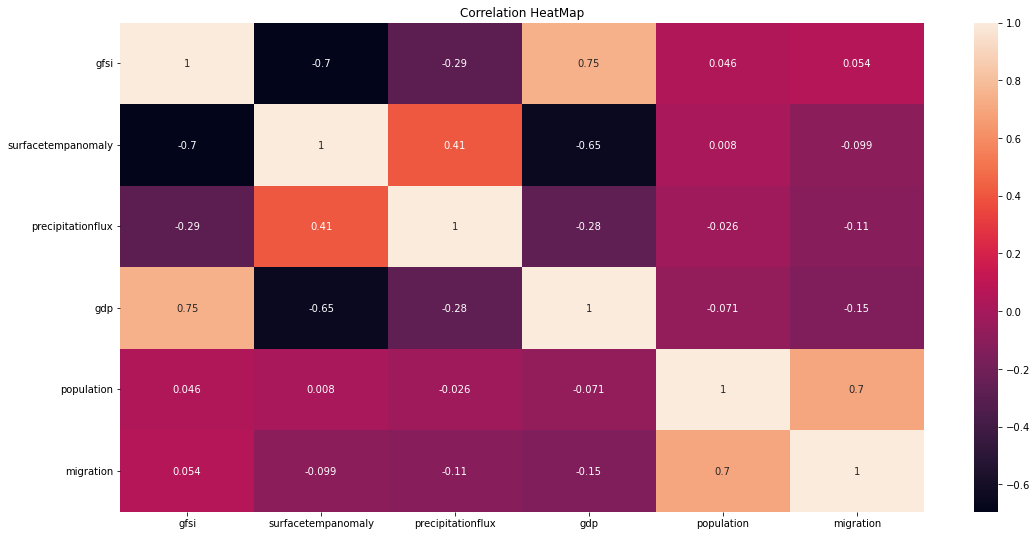

In [107]:
correl = df[['year', 'country-code', 'gfsi', 'surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']].set_index(['year', 'country-code'])
ax, fig = plt.subplots(figsize =(18,9))
sns.heatmap(correl.corr(), annot = True)
plt.title("Correlation HeatMap")



MultiIndex([(2012,  12),
            (2013,  12),
            (2014,  12),
            (2015,  12),
            (2016,  12),
            (2017,  12),
            (2018,  12),
            (2019,  12),
            (2020,  12),
            (2012,  24),
            ...
            (2020, 887),
            (2012, 716),
            (2013, 716),
            (2014, 716),
            (2015, 716),
            (2016, 716),
            (2017, 716),
            (2018, 716),
            (2019, 716),
            (2020, 716)],
           names=['year', 'country-code'], length=999)

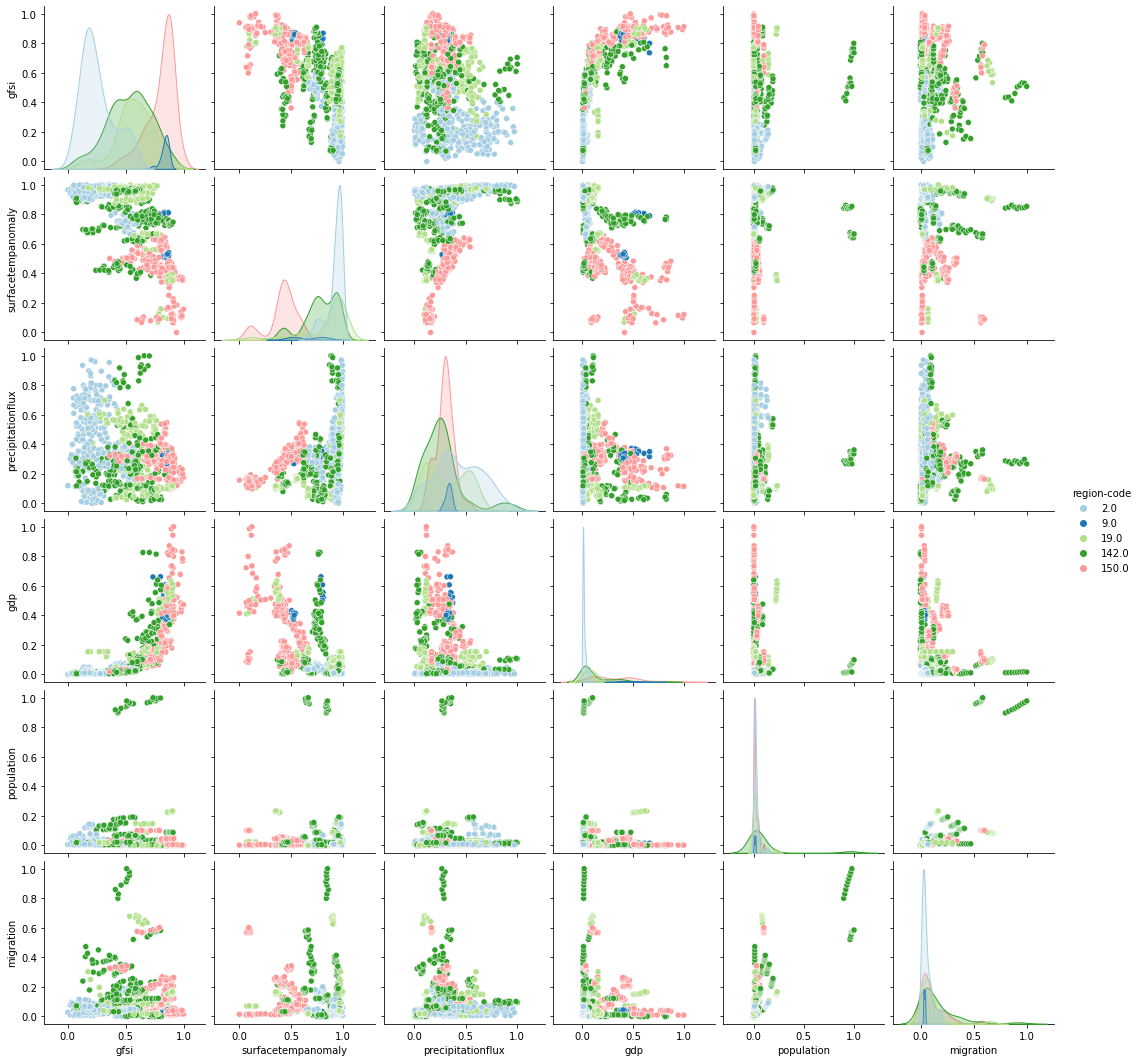

In [115]:
z = df.loc[:,['region-code', 'gfsi', 'surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']]
sns.pairplot(z, hue='region-code', palette="Paired")



In [66]:
y = df['gfsi']
X = df[['surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']]

function_dict = {'predictor': [], 'r-squared':[]}
for col in X.columns:
    selected_X = X[[col]]
    model = sm.OLS(y, sm.add_constant(selected_X)).fit()
    y_preds = model.predict(sm.add_constant(selected_X))
    function_dict['predictor'].append(col)
    r2 = np.corrcoef(y, y_preds)[0, 1]**2
    function_dict['r-squared'].append(r2)
    
function_df = pd.DataFrame(function_dict).sort_values(by=['r-squared'], ascending = False)

display(function_df.head())

,predictor,r-squared
2,gdp,0.555463
0,surfacetempanomaly,0.483169
1,precipitationflux,0.081702
4,migration,0.002931
3,population,0.002089


In [67]:
def next_possible_feature (X_npf, y_npf, current_features, ignore_features=[]):
    '''
    This function will loop through each column that isn't in your feature model and 
    calculate the r-squared value if it were the next feature added to your model. 
    It will display a dataframe with a sorted r-squared value.
    X_npf = X dataframe
    y_npf = y dataframe
    current_features = list of features that are already in your model
    ignore_features = list of unused features we want to skip over
    '''   
    function_dict = {'predictor': [], 'r-squared':[]}

    for col in X_npf.columns:
        if col not in (current_features+ignore_features):
            selected_X = X_npf[current_features + [col]]
            model = sm.OLS(y_npf, sm.add_constant(selected_X)).fit()
            y_preds = model.predict(sm.add_constant(selected_X))
            function_dict['predictor'].append(col)
            r2 = np.corrcoef(y_npf, y_preds)[0, 1]**2
            function_dict['r-squared'].append(r2)
    function_df = pd.DataFrame(function_dict).sort_values(by=['r-squared'],\
                                                          ascending = False)
    display(function_df.head())

In [117]:
selected_features = ['surfacetempanomaly']
features_to_ignore = []
next_possible_feature (X_npf=X, y_npf=y, current_features=selected_features, ignore_features=[features_to_ignore])

,predictor,r-squared
1,gdp,0.633360
2,population,0.485798
3,migration,0.483397
0,precipitationflux,0.483176


In [118]:
vif_3 = pd.DataFrame()
X_3 = X[['surfacetempanomaly', 'gdp']]
vif_3["features"] = X_3.columns
vif_3["VIF"] = [variance_inflation_factor(X_3.values, i) \
                for i in range(len(X_3.columns))]
vif_3

,features,VIF
0,surfacetempanomaly,1.190516
1,gdp,1.190516


## Regression

In [119]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [120]:
dfs = df[['year', 'gfsi', 'surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']].groupby('year').mean()

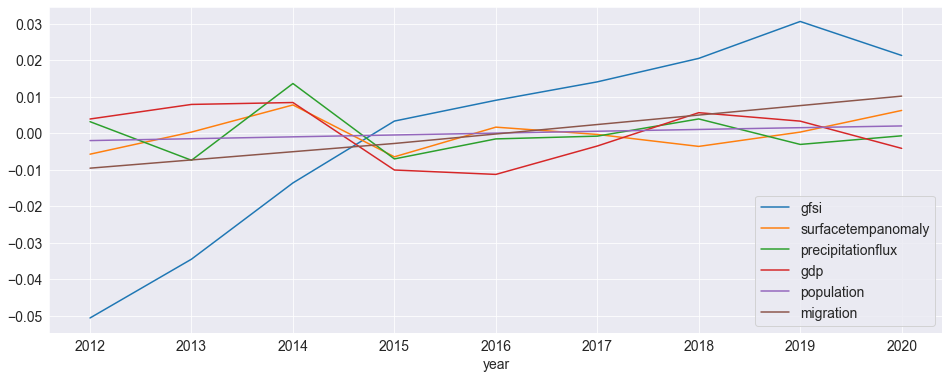

In [121]:
_ = (dfs - dfs.mean()).plot()

In [248]:
df_in = df[['year', 'country-code', 'gfsi', 'surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']].set_index(['year'])

In [249]:
df_in.index = pd.to_datetime(df_in.index, format='%Y')

In [250]:
df_in

,country-code,gfsi,surfacetempanomaly,precipitationflux,gdp,population,migration
year,,,,,,,
2012-01-01,12,0.408503,0.809657,0.216945,0.052237,0.025087,0.095596
2013-01-01,12,0.373383,0.792927,0.248590,0.051335,0.025623,0.097627
2014-01-01,12,0.486137,0.807242,0.255665,0.051272,0.026180,0.099658
2015-01-01,12,0.500924,0.809971,0.315983,0.038464,0.026750,0.101689
2016-01-01,12,0.587800,0.784674,0.249411,0.036210,0.027335,0.103771
...,...,...,...,...,...,...,...
2016-01-01,716,0.207024,0.899491,0.457260,0.012040,0.008511,0.065035
2017-01-01,716,0.127542,0.906662,0.431102,0.009806,0.008657,0.065890
2018-01-01,716,0.199630,0.922352,0.578945,0.009996,0.008801,0.066744


In [251]:
df_in

,country-code,gfsi,surfacetempanomaly,precipitationflux,gdp,population,migration
year,,,,,,,
2012-01-01,12,0.408503,0.809657,0.216945,0.052237,0.025087,0.095596
2013-01-01,12,0.373383,0.792927,0.248590,0.051335,0.025623,0.097627
2014-01-01,12,0.486137,0.807242,0.255665,0.051272,0.026180,0.099658
2015-01-01,12,0.500924,0.809971,0.315983,0.038464,0.026750,0.101689
2016-01-01,12,0.587800,0.784674,0.249411,0.036210,0.027335,0.103771
...,...,...,...,...,...,...,...
2016-01-01,716,0.207024,0.899491,0.457260,0.012040,0.008511,0.065035
2017-01-01,716,0.127542,0.906662,0.431102,0.009806,0.008657,0.065890
2018-01-01,716,0.199630,0.922352,0.578945,0.009996,0.008801,0.066744


In [252]:
sel_res = ardl_select_order(
    df_in.gfsi, 3, df_in[['surfacetempanomaly', 'gdp']], 3, ic="aic", trend="c"
)
print(f"The optimal order is: {sel_res.model.ardl_order}")

The optimal order is: (1, 1, 1)


/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provid

In [253]:
res = sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                   gfsi   No. Observations:                  999
Model:                  ARDL(1, 1, 1)   Log Likelihood                1105.301
Method:               Conditional MLE   S.D. of innovations              0.080
Date:                Wed, 08 Jun 2022   AIC                          -2196.602
Time:                        01:54:57   BIC                          -2162.262
Sample:                             1   HQIC                         -2183.550
                                  999                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0955      0.017      5.609      0.000       0.062       0.129
gfsi.L1                   0.8563      0.016     52.302      0.000       0.824       0.888
surfacetempanomaly.L0    -0.4649      0.027    -17.221      0.000      -0.518      -0.412
surfacetempanomaly.L1     0.4173      0.028     15.011      0.000       0.363       0.472
gdp.L0                    0.5488      0.036     15.200      0.000       0.478       0.620
gdp.L1                   -0.4393      0.038    -11.670      0.000      -0.513      -0.365
=========================================================================================
"""

In [254]:
sel_res = ardl_select_order(
    df_in.gfsi, 3, df_in[['surfacetempanomaly', 'gdp']], 3, ic="bic", trend="c", glob=True
)
sel_res.model.ardl_order

/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provid

(1, 1, 1)

In [255]:
sel_res.model.ar_lags

[1]

In [256]:
sel_res.model.dl_lags

{'surfacetempanomaly': [0, 1], 'gdp': [0, 1]}

In [257]:
for i, val in enumerate(sel_res.bic.head(10)):
    print(f"{i+1}: {val}")

1: ((1,), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1)})
2: ((1, 3), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1)})
3: ((1, 2), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1)})
4: ((1,), {'surfacetempanomaly': (0, 1, 2), 'gdp': (0, 1)})
5: ((1,), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1, 2)})
6: ((1,), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1, 3)})
7: ((1,), {'surfacetempanomaly': (0, 1, 3), 'gdp': (0, 1)})
8: ((1, 3), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1, 3)})
9: ((1, 3), {'surfacetempanomaly': (0, 1, 3), 'gdp': (0, 1)})
10: ((1, 2), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1, 3)})


In [258]:
res = sel_res.model.fit()
print(res.summary())

                              ARDL Model Results                              
Dep. Variable:                   gfsi   No. Observations:                  999
Model:                  ARDL(1, 1, 1)   Log Likelihood                1105.301
Method:               Conditional MLE   S.D. of innovations              0.080
Date:                Wed, 08 Jun 2022   AIC                          -2196.602
Time:                        01:55:25   BIC                          -2162.262
Sample:                             1   HQIC                         -2183.550
                                  999                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0955      0.017      5.609      0.000       0.062       0.129
gfsi.L1                   0.8563      0.016     52.302      0.000       0.824       0.888
surfacet

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


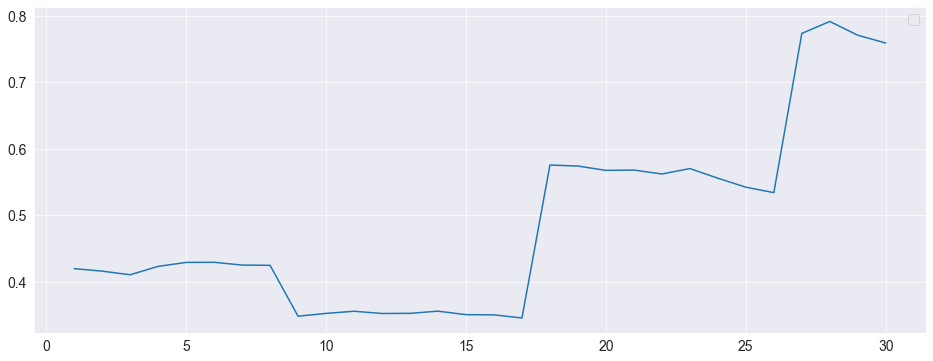

In [259]:
fig = res.plot_predict(1, 30, True)



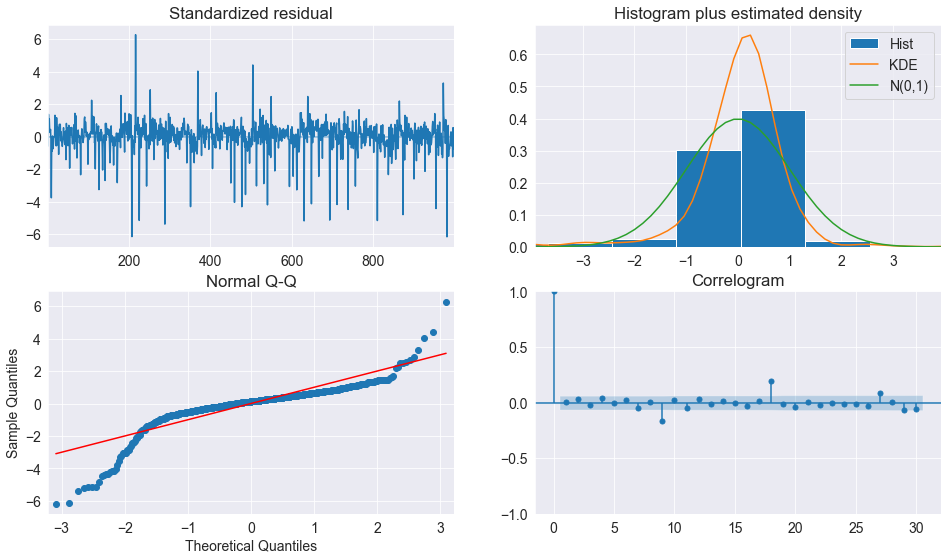

In [260]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [216]:
df_in[df_in['country-code'] == 12][['surfacetempanomaly', 'gdp']]

,surfacetempanomaly,gdp
year,,
2012,0.809657,0.052237
2013,0.792927,0.051335
2014,0.807242,0.051272
2015,0.809971,0.038464
2016,0.784674,0.036210
2017,0.776340,0.037800
2018,0.778322,0.038115
2019,0.787383,0.036631
2020,0.782219,0.029981


In [261]:
print(res.forecast(exog=df_in[['surfacetempanomaly', 'gdp']]))

999    0.248914
dtype: float64


/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


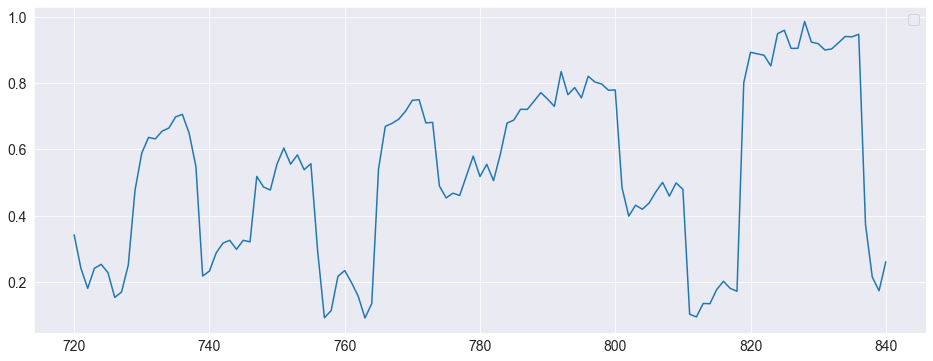

In [262]:
fig = res.plot_predict(720, 840)

In [272]:
start = df_in.index[-90]
print(df_in.index.year)

Int64Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2012,
            ...
            2020, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
           dtype='int64', name='year', length=999)


In [270]:
pd.date_range(2012, freq=df_in.index.freq, periods=12)

ValueError: Invalid frequency: DatetimeIndex(['2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2012-01-01',
               ...
               '2020-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
               '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='year', length=999, freq=None)

In [ ]:
import numpy as np

start = df_in.index[-90]
forecast_index = ['2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01']
cols = ["-".join(str(val) for val in (idx.year, idx.month)) for idx in forecast_index]
forecasts = pd.DataFrame(index=forecast_index, columns=cols)
for i in range(1, 24):
    fcast = res.predict(
        start=forecast_index[i], end=forecast_index[i + 12], dynamic=True
    )
    forecasts.loc[fcast.index, cols[i]] = fcast
_, ax = plt.subplots(figsize=(16, 10))
ind_prod.iloc[-24:].plot(ax=ax, color="black", linestyle="--")
ax = forecasts.plot(ax=ax)

